## Предсказание победы по данным о первых 5 минутах игры Dota 2  с помощью python

Загружаем все необходимые библиотеки для дальнейшей работы и прописываем `%matplotlib inline` для отображения всех графиков внутри Jupyter Notebook.

In [1]:
import pandas
import scipy
import numpy
import math
import time
import datetime
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

Загружаем исходные данные, смотрим длину выборки и выводим для проверки первые несколько строк.

In [2]:
features = pandas.read_csv(u'features.csv', 
                           index_col='match_id')
print len(features)
features.head()

97230


,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16,2449,0,4,1974,3,63


Нескольких столбцов нет в финальной тестовой выборке - уберем их все, кроме целевой переменной '**radiant_win**'. Также среди оставшихся столбцов найдем столбцы с пропусками и выведем для них количество пропусков.

In [3]:
cols = [col for col in features.columns if col not in ['start_time',
                                                       'duration', 
                                                       'tower_status_radiant', 
                                                       'tower_status_dire', 
                                                       'barracks_status_radiant',
                                                       'barracks_status_dire']]
features_u = features[cols]
nans = len(features) - features_u.count()
print nans[nans != 0]

first_blood_time               19553
first_blood_team               19553
first_blood_player1            19553
first_blood_player2            43987
radiant_bottle_time            15691
radiant_courier_time             692
radiant_flying_courier_time    27479
radiant_first_ward_time         1836
dire_bottle_time               16143
dire_courier_time                676
dire_flying_courier_time       26098
dire_first_ward_time            1826
dtype: int64


Попробуем обосновать наличие пропусков:

*`first_blood_time`*               - в течении первых 5 минут не наступило событие 'первая кровь';  
*`first_blood_team`*               - т.к. 'первая кровь' не наступило - нет команды, совершившей событие;  
*`first_blood_player1`*            - т.к. 'первая кровь' не наступило - нет игрока, совершившего событие;  
*`first_blood_player2`*            - т.к. 'первая кровь' не наступило - нет игрока, помогшего совершить событие;  
*`radiant_bottle_time`*            - в течении первых 5 минут не было приобретения предмета "bottle" командой radiant;  
*`radiant_courier_time`*           - в течении первых 5 минут не было приобретения предмета "courier" командой radiant;  
*`radiant_flying_courier_time`*    - в течении первых 5 минут не было приобретения предмета "flying_courier" командой radiant;  
*`radiant_first_ward_time`*        - в течении первых 5 минут командой radiant не был установлен ни один "наблюдатель";  
*`dire_bottle_time`*               - в течении первых 5 минут не было приобретения предмета "bottle" командой dire;  
*`dire_courier_time`*              - в течении первых 5 минут не было приобретения предмета "courier" командой dire;  
*`dire_flying_courier_time`*       - в течении первых 5 минут не было приобретения предмета "flying_courier" командой dire;  
*`dire_first_ward_time`*           - в течении первых 5 минут командой dire не был установлен ни один "наблюдатель".  

Заполним все пропуски нулевыми значениями:

In [4]:
features_u = features_u.fillna(value = 0)

Разделим полученные данные на целевую переменную *y* и матрицу признаков *X* (целевая переменная находится в столбце '**radiant_win**'):

In [5]:
y = features_u['radiant_win']
X = features_u.drop('radiant_win', 1)

Т.к. компьютер не очень мощный и с небольшим количество оперативной памяти - сделаем подвыборку исходных данных и в дальнейшем будем работать с этой подвыборкой. От общего числа возьмем половину данных:

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size = 0.5, 
                                                    random_state = 1)
X = X_train
y = y_train

Теперь полученную подвыборку разобъем на обучающую и тестовую части - в соотношении 1:1 - чтобы еще уменьшить нагрузку на компьютер:

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.5, 
                                                    random_state = 1)

Зафиксируем генератор разбиений для кросс-валидации:

In [8]:
kF = KFold(n = len(y_train),
          random_state = 1,
          n_folds = 5,
          shuffle = True)

## Градиентный бустинг

Создадим классификатор, использующий метод градиентного бустинга (GradientBoostingClassifier):

In [9]:
clf = GradientBoostingClassifier(verbose = 0,
                                random_state = 1)

Проведем поиск по сетке параметров - в качестве параметра будет выступать количество деревьев '*n_estimators*':

In [10]:
params = {'n_estimators':[10, 20, 30]}
clf_grid = GridSearchCV(clf, 
                        params,
                        cv = kF,
                        scoring = 'roc_auc'
                       )
clf_grid.fit(X_train, y_train)

GridSearchCV(cv=sklearn.cross_validation.KFold(n=24307, n_folds=5, shuffle=True, random_state=1),
       error_score='raise',
       estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=1, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20, 30]}, pre_dispatch='2*n_jobs',
       refit=True, scoring='roc_auc', verbose=0)

Т.к. мерой качества выступает *ROC_AUC* выведем графики метрики наилучшего классификатора для обучающей и тестовой выборок, а также график зависимости *ROC_AUC* от количества деревьев в бустинге:

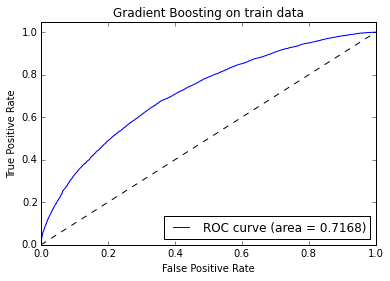

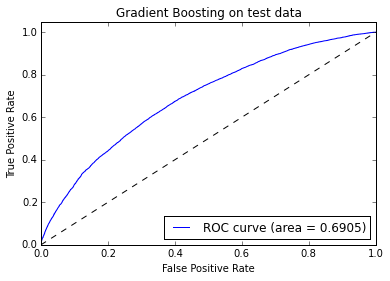

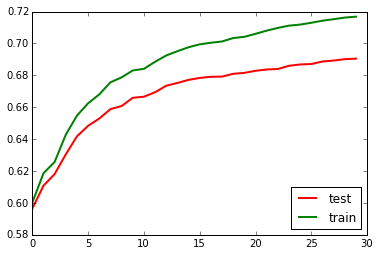

In [11]:
y_train_score = clf_grid.decision_function(X_train)
y_test_score = clf_grid.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_train, y_train_score)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label = u'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boosting on train data')
plt.legend(loc = "lower right")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_test_score)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label = u'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boosting on test data')
plt.legend(loc = "lower right")
plt.show()

y_score_train = numpy.empty(len(clf_grid.best_estimator_.estimators_))
y_score_test = numpy.empty(len(clf_grid.best_estimator_.estimators_))
n = 0
for i, x in enumerate(clf_grid.best_estimator_.staged_decision_function(X_train) ):
    y_score_train[i] = roc_auc_score(y_train, x)
for i, x in enumerate(clf_grid.best_estimator_.staged_decision_function(X_test) ):
    y_score_test[i] = roc_auc_score(y_test, x)

plt.figure()
plt.plot(y_score_test, 'r', linewidth = 2)
plt.plot(y_score_train, 'g', linewidth = 2)
plt.legend(['test', 'train'], loc="lower right")

Из последнего графика видно, что увеличение количества классификаторов имеет смысл, т.к. график качества от количества деревьев еще не вышел на плато.

Замерим время обучения классификатора на 30 деревьях и выведем значение метрики качества:

In [12]:
clf_1 = GradientBoostingClassifier(verbose = 0,
                                random_state = 1,
                                n_estimators = 30)
start_time = datetime.datetime.now()
val = cross_val_score(estimator = clf_1,
                     X = X_train,
                     y = y_train,
                     scoring = 'roc_auc',
                     cv = kF)

print 'Time elapsed:', datetime.datetime.now() - start_time
print 'ROC_AUC:', str(val.mean())

Time elapsed: 0:00:44.169000
ROC_AUC: 0.68301465789


Для ускорения процесса обучения можно уменьшить глубину деревьев.

## Логистическая регрессия

Отмасштабируем исходные переменные:

In [13]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = pandas.DataFrame(scaler.transform(X))
X_scaled.columns = X.columns

Разобъем отмасштабированные данные на тестовую и обучающую выборки:

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                                                    y, 
                                                    test_size = 0.5, 
                                                    random_state = 1)

Проведем поиск по сетке параметров - в качестве параметра будет выступать коэффициент регуляризации '*C*':

In [15]:
logreg_grid = {'C': numpy.power(10.0, numpy.arange(-5, 6, 1))}
clf_logreg = LogisticRegression(random_state = 1, verbose = 0)
clf_logreg_grid = GridSearchCV(clf_logreg, 
                               logreg_grid,
                               cv = kF,
                               scoring = 'roc_auc'
                               )
clf_logreg_grid.fit(X_train, y_train)

GridSearchCV(cv=sklearn.cross_validation.KFold(n=24307, n_folds=5, shuffle=True, random_state=1),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03,   1.00000e+04,   1.00000e+05])},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

Выведем лучший параметр регуляризации и значение метрики на обученном классификаторе для обучающей и тестовой выборок:

In [16]:
y_train_score_logreg = clf_logreg_grid.decision_function(X_train)
y_test_score_logreg = clf_logreg_grid.decision_function(X_test)

print clf_logreg_grid.best_params_
print roc_auc_score(y_train, y_train_score_logreg)
print roc_auc_score(y_test, y_test_score_logreg)

{'C': 0.01}
0.718391245389
0.718548923108


Полученное значение метрики с использованием логистической регрессии выше значения метрики, полученного с помощью градиентного бустинга. Это может быть вызвано тем, что данные линейно разделимы в заданном признаковом пространстве, или, например, при использовании бустинга использовалось недостаточное количество деревьев. Логистическая регрессия работает быстрее градиентного бустинга.

Уберем из данных категориальные переменные:

In [17]:
cols = [col for col in X_scaled.columns if col not in ['r1_hero', 'd1_hero', 
                                                       'r2_hero', 'd2_hero', 
                                                       'r3_hero', 'd3_hero', 
                                                       'r4_hero', 'd4_hero', 
                                                       'r5_hero', 'd5_hero', 
                                                       'lobby_type']]
X_log = X_scaled[cols]

Повторим процедуру обучения на новых данных, выведем лучший параметр регуляризации и значение метрики на лучшем классификаторе для обучющей и тестовой выборок:

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_log, 
                                                    y, 
                                                    test_size = 0.5, 
                                                    random_state = 1)
clf_logreg_grid.fit(X_train, y_train)

y_train_score_logreg = clf_logreg_grid.decision_function(X_train)
y_test_score_logreg = clf_logreg_grid.decision_function(X_test)

print clf_logreg_grid.best_params_
print roc_auc_score(y_train, y_train_score_logreg)
print roc_auc_score(y_test, y_test_score_logreg)

{'C': 0.01}
0.718132338083
0.718505641938


Видно, что значение метрики практически не изменилось. Это означает, что данные переменные при использовании метода логистической регресии вероятно не дают дополнительной информации о победителе, что логично, т.к. номера героев не связаны количественно и порядково с характеристиками героев.

Выведем количество различных идентификаторов героев в выборке, максимальный номер героя и график частоты использования героев:

108
112


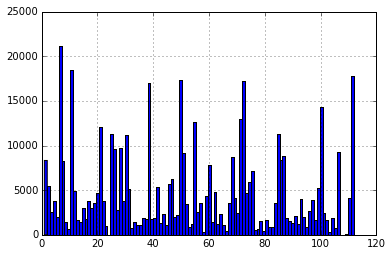

In [19]:
cols = [col for col in X_scaled.columns if col in ['r1_hero', 'd1_hero', 
                                                       'r2_hero', 'd2_hero', 
                                                       'r3_hero', 'd3_hero', 
                                                       'r4_hero', 'd4_hero', 
                                                       'r5_hero', 'd5_hero']]

Heroes = X[cols].stack()
N = len(Heroes.unique())
print N
print Heroes.unique().max()
Heroes.hist(bins = N)

Создадим '*мешок слов*' для героев и добавим его к отмасштабированным данным:

In [20]:
N = Heroes.max()

X_pick = numpy.zeros((X.shape[0], N))

for i, match_id in enumerate(X.index):
    for p in xrange(5):
        X_pick[i, X.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, X.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1
        
X_pick_df = pandas.DataFrame(X_pick)
X_pick_df.columns = range(1, 113)
cols = [col for col in X_pick_df.columns if col in Heroes.unique()]
X_pick_df = X_pick_df[cols]

X_fin = pandas.concat([X_log, X_pick_df], axis = 1)

Повторим обучение логистической регрессии на вновь полученном наборе данных и выведем значение метрики качества на лучшем обученном классификаторе:

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_fin, 
                                                    y,
                                                    test_size = 0.5, 
                                                    random_state = 1)

clf_logreg_grid.fit(X_train, y_train)

y_train_score_logreg = clf_logreg_grid.decision_function(X_train)
y_test_score_logreg = clf_logreg_grid.decision_function(X_test)

print clf_logreg_grid.best_params_
print roc_auc_score(y_train, y_train_score_logreg)
print roc_auc_score(y_test, y_test_score_logreg)

{'C': 0.10000000000000001}
0.754204451475
0.751909211569


Видно, что полученное значение метрики выше, чем было без мешка слов. Это можно объяснить тем, что теперь каждый герой кодируется отдельной переменной и между идентификаторами героев нет количественных и порядковых взаимосвязей, что хорошо подходит для логистической регрессии.

## Тестовые данные и kaggle

Лучшей моделью из трех вышерасмотренных оказалась оказалась модель логистической регрессии с кодированием героев с помощью '*мешка слов*'. Эту модель и будем использовать на предоставленной тестовой выборке. Загрузим данные и подготовим их для используемой модели:

In [22]:
real_test_data = pandas.read_csv(u'features_test.csv', 
                           index_col='match_id')

real_test_data = real_test_data.fillna(value = 0)
cols = [col for col in real_test_data.columns if col != 'start_time']

NN = len(real_test_data)
X_pick_1 = numpy.zeros((NN, N))

for i, match_id in enumerate(real_test_data.index):
    for p in xrange(5):
        X_pick_1[i, real_test_data.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick_1[i, real_test_data.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1

X_pick_df_1 = pandas.DataFrame(X_pick_1)
X_pick_df_1.columns = range(1, 113)
cols = [col for col in X_pick_df_1.columns if col in Heroes.unique()]

X_pick_df_1 = X_pick_df_1[cols]
X_pick_df_1.head()

cols = [col for col in real_test_data.columns if col not in ['start_time',
                                                       'duration', 
                                                       'tower_status_radiant', 
                                                       'tower_status_dire', 
                                                       'barracks_status_radiant',
                                                       'barracks_status_dire']]

X_scaled_1 = pandas.DataFrame(scaler.transform(real_test_data[cols]))
X_scaled_1.columns = real_test_data[cols].columns
cols = [col for col in real_test_data.columns if col not in ['start_time',
                                                       'duration', 
                                                       'tower_status_radiant', 
                                                       'tower_status_dire', 
                                                       'barracks_status_radiant',
                                                       'barracks_status_dire',
                                                       'r1_hero', 'd1_hero', 
                                                       'r2_hero', 'd2_hero', 
                                                       'r3_hero', 'd3_hero', 
                                                       'r4_hero', 'd4_hero', 
                                                       'r5_hero', 'd5_hero',
                                                            'lobby_type']]
X_fin_1 = pandas.concat([X_scaled_1[cols], X_pick_df_1], axis = 1)

Рассчитаем требуемые вероятности с помощью прежде обученной модели, проверим их на адекватность, сохраним результат в *.csv* файл и загрузим результат на *kaggle*:

In [24]:
logistic = clf_logreg_grid.best_estimator_.predict_proba(X_fin_1)
result = pandas.DataFrame(zip(real_test_data.index, logistic[:, 1]))
result.columns = ['match_id', 'radiant_win']

print 'Min probability:', str(min(result['radiant_win']))
print 'Max probability:', str(max(result['radiant_win']))
result.to_csv(u'result_k.csv',
             index = False)

Min probability: 0.0116143918278
Max probability: 0.996198568899


Результат первой загруженной попытки на *kaggle* - **0.75113** (Dreamastiy).